# Weight Initialization

In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data

## NeuralNetwork

In [2]:
class NeuralNetwork:
    
    def build(self, weights):
        print('Building network ...')
        self.features, self.labels, self.learn_rate = self.create_placeholders()
        self.biases = self.create_biases(output_nums)
        self.logits = self.build_layers(self.features, weights, self.biases)
        self.loss, self.optimizer = self.add_loss_and_optimizer(self.logits, self.labels, self.learn_rate)
        self.accuracy = self.add_accuracy(self.logits, self.labels)
        print('Network Built!\n')
    
    def create_placeholders(self):
        features = tf.placeholder(tf.float32)
        labels = tf.placeholder(tf.float32)
        learn_rate = tf.placeholder(tf.float32)
        return features, labels, learn_rate

    def create_biases(self, output_nums):
        biases = [
            tf.Variable(tf.zeros([output_nums[0]])),
            tf.Variable(tf.zeros([output_nums[1]])),
            tf.Variable(tf.zeros([output_nums[2]]))
        ]
        return biases
    
    def build_layers(self, x, weights, biases):
        layer_1 = tf.nn.relu(tf.add(tf.matmul(x, weights[0]), biases[0]))
        layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1, weights[1]), biases[1]))
        logits = tf.add(tf.matmul(layer_2, weights[2]), biases[2])
        return logits
    
    def add_loss_and_optimizer(self, logits, labels, learn_rate):
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels)
        loss = tf.reduce_mean(cross_entropy)
        optimizer = tf.train.AdamOptimizer(learn_rate).minimize(loss)
        return loss, optimizer
    
    def add_accuracy(self, logits, labels):
        correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        return accuracy

## NetworkTrainer

In [3]:
class NetworkTrainer:
    
    def train_network(self, network, weights):
        """
        Get losses and validation accuracy of example neural network
        """
        
        print('Training network ...')
        
        losses = []
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            
            n_batches = int((dataset.train.num_examples//batch_size))
            
            # Training cycle
            for epoch_i in range(epochs):
                
                for batch_i in range(n_batches):
                    batch_features, batch_labels = dataset.train.next_batch(batch_size)
                    
                    sess.run(network.optimizer,
                             feed_dict={network.features: batch_features,
                                        network.labels: batch_labels,
                                        network.learn_rate: learning_rate})
                    
                    loss = sess.run(network.loss,
                                    feed_dict={network.features: batch_features,
                                               network.labels: batch_labels,
                                               network.learn_rate: learning_rate})
                    
                    losses.append(loss)
                    
            # Compute validation accuracy
            valid_acc = sess.run(network.accuracy,
                                 feed_dict={network.features: dataset.validation.images,
                                            network.labels: dataset.validation.labels,
                                            network.learn_rate: 1.0})
            
        # Hack to reset batches
        dataset.train._index_in_epoch = 0
        dataset.train._epochs_completed = 0

        print('Network Trained!\n')
        
        return losses, valid_acc

## InitWeightApplicator

In [4]:
class InitWeightApplicator:
    
    def apply_init_weights(self, title, weight_init_list, plot_n):
        
        """
        Plot loss and print stats of weights using an example neural network
        """
        
        print('Applying weights: {}\n'.format(title))
        
        colors = ['r', 'b', 'g', 'c', 'y', 'k']
        label_accs = []
        label_loss = []

        assert len(weight_init_list) <= len(colors), 'Too many inital weights to plot'

        for i, (label, weights) in enumerate(weight_init_list):
            network = NeuralNetwork()
            network.build(weights)
            
            trainer = NetworkTrainer()
            losses, val_acc = trainer.train_network(network, weights)

            plt.plot(losses[:plot_n], colors[i], label=label)
            label_accs.append((label, val_acc))
            label_loss.append((label, losses[-1]))
            
        self.plot(title, label_accs, label_loss)

    def plot(self, title, label_accs, label_loss):
        plt.title(title)
        plt.xlabel('Batches')
        plt.ylabel('Loss')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()

        print('After 858 Batches (2 Epochs):')
        print('Validation Accuracy')
        for label, val_acc in label_accs:
            print('  {:7.3f}% -- {}'.format(val_acc*100, label))
        
        print('Loss')
        for label, loss in label_loss:
            print('  {:7.3f}  -- {}'.format(loss, label))

In [5]:
print('Getting MNIST Dataset...')
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
print('Data Extracted.')

Getting MNIST Dataset...
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Data Extracted.


In [6]:
layer_1_weight_shape = (mnist.train.images.shape[1], 256)
layer_2_weight_shape = (256, 128)
layer_3_weight_shape = (128, mnist.train.labels.shape[1])

# [256, 128, 10]
output_nums = [layer_1_weight_shape[1], layer_2_weight_shape[1], layer_3_weight_shape[1]] 

learning_rate = 0.001
batch_size = 128
epochs = 2
plot_n_batches = 100

dataset = mnist
all_zero_weights = [
    tf.Variable(tf.zeros(layer_1_weight_shape)),
    tf.Variable(tf.zeros(layer_2_weight_shape)),
    tf.Variable(tf.zeros(layer_3_weight_shape))
]

all_one_weights = [
    tf.Variable(tf.ones(layer_1_weight_shape)),
    tf.Variable(tf.ones(layer_2_weight_shape)),
    tf.Variable(tf.ones(layer_3_weight_shape))
]

# Uniform Distribution [0, 1)
baseline_weights = [
    tf.Variable(tf.random_uniform(layer_1_weight_shape)),
    tf.Variable(tf.random_uniform(layer_2_weight_shape)),
    tf.Variable(tf.random_uniform(layer_3_weight_shape))
]

# Uniform Distribution [-1,1)
uniform_neg1to1_weights = [
    tf.Variable(tf.random_uniform(layer_1_weight_shape, -1, 1)),
    tf.Variable(tf.random_uniform(layer_2_weight_shape, -1, 1)),
    tf.Variable(tf.random_uniform(layer_3_weight_shape, -1, 1))
]

# Uniform Distribution [-0.1, 0.1)
uniform_neg01to01_weights = [
    tf.Variable(tf.random_uniform(layer_1_weight_shape, -0.1, 0.1)),
    tf.Variable(tf.random_uniform(layer_2_weight_shape, -0.1, 0.1)),
    tf.Variable(tf.random_uniform(layer_3_weight_shape, -0.1, 0.1))
]

# Uniform Distribution [-0.01, 0.01)
uniform_neg001to001_weights = [
    tf.Variable(tf.random_uniform(layer_1_weight_shape, -0.01, 0.01)),
    tf.Variable(tf.random_uniform(layer_2_weight_shape, -0.01, 0.01)),
    tf.Variable(tf.random_uniform(layer_3_weight_shape, -0.01, 0.01))
]

# Uniform Distribution [-0.001, 0.001)
uniform_neg0001to0001_weights = [
    tf.Variable(tf.random_uniform(layer_1_weight_shape, -0.001, 0.001)),
    tf.Variable(tf.random_uniform(layer_2_weight_shape, -0.001, 0.001)),
    tf.Variable(tf.random_uniform(layer_3_weight_shape, -0.001, 0.001))
]

# General Rule: 1 / sqrt(n)
general_rule_weights = [
    tf.Variable(tf.random_uniform(layer_1_weight_shape, -1/np.sqrt(layer_1_weight_shape[0]), 1/np.sqrt(layer_1_weight_shape[0]))),
    tf.Variable(tf.random_uniform(layer_2_weight_shape, -1/np.sqrt(layer_2_weight_shape[0]), 1/np.sqrt(layer_2_weight_shape[0]))),
    tf.Variable(tf.random_uniform(layer_3_weight_shape, -1/np.sqrt(layer_3_weight_shape[0]), 1/np.sqrt(layer_3_weight_shape[0])))
]

# Normal Distribution, mean=0.0, stddev=0.1
normal_01_weights = [
    tf.Variable(tf.random_normal(layer_1_weight_shape, stddev=0.1)),
    tf.Variable(tf.random_normal(layer_2_weight_shape, stddev=0.1)),
    tf.Variable(tf.random_normal(layer_3_weight_shape, stddev=0.1))
]

# Truncated Normal Distribution, mean=0.0, stddev=0.1
trunc_normal_01_weights = [
    tf.Variable(tf.truncated_normal(layer_1_weight_shape, stddev=0.1)),
    tf.Variable(tf.truncated_normal(layer_2_weight_shape, stddev=0.1)),
    tf.Variable(tf.truncated_normal(layer_3_weight_shape, stddev=0.1))
]

weight_dict = {
    'All Zeros': all_zero_weights,
    'All Ones': all_one_weights,
    'Baseline Random Uniform [0, 1)': baseline_weights,
    'Random Uniform [-1, 1)': uniform_neg1to1_weights,
    'Random Uniform [-0.1, 0.1)': uniform_neg01to01_weights,
    'Random Uniform [-0.01, 0.01)': uniform_neg001to001_weights,
    'Random Uniform [-0.001, 0.001)': uniform_neg0001to0001_weights,
    'General Rule': general_rule_weights,
    'Random Normal stddev=0.1': normal_01_weights,
    'Truncated Normal stddev=0.1': trunc_normal_01_weights
} 

## InitialWeightExperiment

In [7]:
class InitialWeightExperiment:
     
    def run_all_zeros_ones(self):
        title = 'All Zeros vs All Ones'
        weight_init_list = [('All Zeros', weight_dict['All Zeros']),
                            ('All Ones', weight_dict['All Ones'])]
        
        self.run(title, weight_init_list)
        
    def run_uniform_dist_baseline(self):
        self.display_distribution('Random Uniform (minval=-3, maxval=3)', 
                                   tf.random_uniform([1000], -3, 3))
        
        title = 'Baseline'
        weight_init_list = [('Baseline Random Uniform [0, 1)', 
                              weight_dict['Baseline Random Uniform [0, 1)'])]
     
        self.run(title, weight_init_list)
    
    def run_baseline_vs_uniform_neg1to1(self):
        title = 'Baseline [0, 1) vs Uniform [-1, 1)'
        weight_init_list = [('Baseline Random Uniform [0, 1)', 
                              weight_dict['Baseline Random Uniform [0, 1)']),
                            ('Random Uniform [-1, 1)', 
                              weight_dict['Random Uniform [-1, 1)'])]
        
        self.run(title, weight_init_list)
    
    def run_small_weights(self):
        title = 'Small Weights'
        weight_init_list = [('Random Uniform [-1, 1)', 
                              weight_dict['Random Uniform [-1, 1)']),
                            ('Random Uniform [-0.1, 0.1)', 
                              weight_dict['Random Uniform [-0.1, 0.1)']),
                            ('Random Uniform [-0.01, 0.01)', 
                              weight_dict['Random Uniform [-0.01, 0.01)']),
                            ('Random Uniform [-0.001, 0.001)',
                              weight_dict['Random Uniform [-0.001, 0.001)'])]

        self.run(title, weight_init_list, None)

    def run_uniform_01_vs_general_rule(self):
        title = 'Uniform [-0.1, 0.1) vs General Rule'
        weight_init_list = [('Random Uniform [-0.1, 0.1)', 
                              weight_dict['Random Uniform [-0.1, 0.1)']),
                            ('General Rule', 
                              weight_dict['General Rule'])]
        
        self.run(title, weight_init_list, None)
    
    def run_uniform_01_vs_random_normal(self):
        self.display_distribution('Random Normal (mean=0.0, stddev=1.0)',
                                   tf.random_normal([1000]))
        
        title = 'Uniform [-0.1, 0.1) vs Normal stddev=0.1'
        weight_init_list = [('Random Uniform [-0.1, 0.1)', 
                              weight_dict['Random Uniform [-0.1, 0.1)']),
                            ('Random Normal stddev=0.1', 
                              weight_dict['Random Normal stddev=0.1'])]
        
        self.run(title, weight_init_list)
    
    def run_random_normal_vs_truncated_normal(self):
        self.display_distribution('Truncated Normal (mean=0.0, stddev=1.0)',
                                   tf.truncated_normal([1000]))
        
        title = 'Random Normal stddev=0.1 vs Truncated Normal stddev=0.1'
        weight_init_list = [('Random Normal stddev=0.1', 
                              weight_dict['Random Normal stddev=0.1']),
                            ('Truncated Normal stddev=0.1',
                              weight_dict['Truncated Normal stddev=0.1'])]
        
        self.run(title, weight_init_list)
        
    def run_baseline_vs_truncated_normal(self):
        title = 'Baseline [0, 1) vs Truncated Normal'
        weight_init_list = [('Baseline Random Uniform [0, 1)', 
                              weight_dict['Baseline Random Uniform [0, 1)']),
                            ('Truncated Normal stddev=0.1',
                              weight_dict['Truncated Normal stddev=0.1'])]
        
        self.run(title, weight_init_list)
    
    def run(self, title, weight_init_list, plot_n=plot_n_batches):
        applicator = InitWeightApplicator()
        applicator.apply_init_weights(title, weight_init_list, plot_n)
    
    def display_distribution(self, title, dist_tensor):
        histCreator = HistogramCreator()
        histCreator.display_histogram(title, dist_tensor)  

### HistogramCreator

In [8]:
class HistogramCreator:
    
    def display_histogram(self, title, distribution_tensor, hist_range=(-4, 4)):
        """
        Display histogram of a TF distribution
        """
        with tf.Session() as sess:
            values = sess.run(distribution_tensor)

        plt.title(title)
        plt.hist(values, np.linspace(*hist_range, num=len(values)/2))
        plt.show()

### All Zeros vs All Ones

Applying weights: All Zeros vs All Ones

Building network ...
Network Built!

Training network ...
Network Trained!

Building network ...
Network Built!

Training network ...
Network Trained!



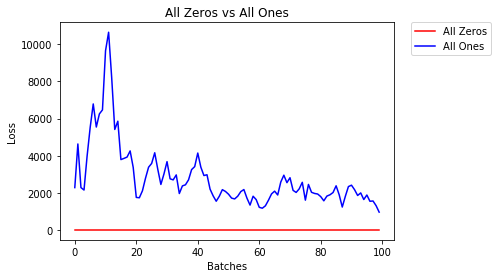

After 858 Batches (2 Epochs):
Validation Accuracy
   11.260% -- All Zeros
    9.760% -- All Ones
Loss
    2.304  -- All Zeros
  250.951  -- All Ones


In [9]:
experiment = InitialWeightExperiment()
experiment.run_all_zeros_ones()

### Uniform Distribution

### Baseline

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # This is added back by InteractiveShellApp.init_path()


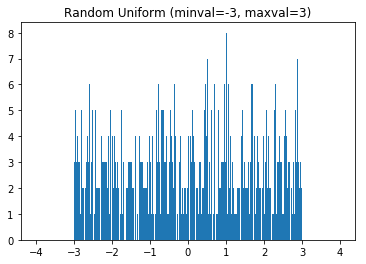

Applying weights: Baseline

Building network ...
Network Built!

Training network ...
Network Trained!



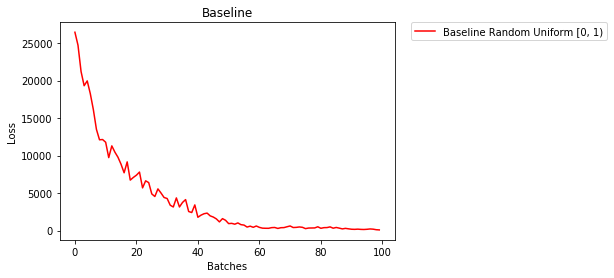

After 858 Batches (2 Epochs):
Validation Accuracy
   78.100% -- Baseline Random Uniform [0, 1)
Loss
   14.982  -- Baseline Random Uniform [0, 1)


In [10]:
experiment.run_uniform_dist_baseline()

### Baseline [0,1) vs Uniform [-1,1)

Applying weights: Baseline [0, 1) vs Uniform [-1, 1)

Building network ...
Network Built!

Training network ...
Network Trained!

Building network ...
Network Built!

Training network ...
Network Trained!



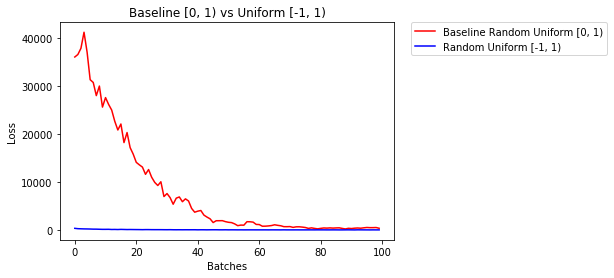

After 858 Batches (2 Epochs):
Validation Accuracy
   71.520% -- Baseline Random Uniform [0, 1)
   90.380% -- Random Uniform [-1, 1)
Loss
   18.953  -- Baseline Random Uniform [0, 1)
    1.633  -- Random Uniform [-1, 1)


In [11]:
experiment.run_baseline_vs_uniform_neg1to1()

### Small Weights

Applying weights: Small Weights

Building network ...
Network Built!

Training network ...
Network Trained!

Building network ...
Network Built!

Training network ...
Network Trained!

Building network ...
Network Built!

Training network ...
Network Trained!

Building network ...
Network Built!

Training network ...
Network Trained!



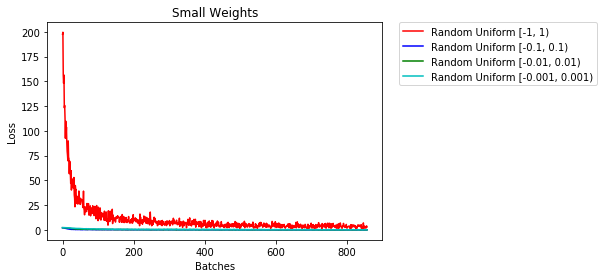

After 858 Batches (2 Epochs):
Validation Accuracy
   91.060% -- Random Uniform [-1, 1)
   97.160% -- Random Uniform [-0.1, 0.1)
   95.820% -- Random Uniform [-0.01, 0.01)
   94.380% -- Random Uniform [-0.001, 0.001)
Loss
    2.955  -- Random Uniform [-1, 1)
    0.077  -- Random Uniform [-0.1, 0.1)
    0.074  -- Random Uniform [-0.01, 0.01)
    0.144  -- Random Uniform [-0.001, 0.001)


In [12]:
experiment.run_small_weights()

### [-0.1, 0.1) vs General Rule

Applying weights: Uniform [-0.1, 0.1) vs General Rule

Building network ...
Network Built!

Training network ...
Network Trained!

Building network ...
Network Built!

Training network ...
Network Trained!



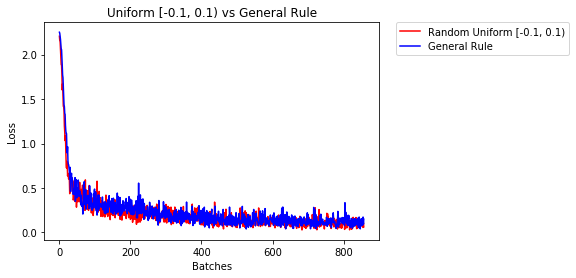

After 858 Batches (2 Epochs):
Validation Accuracy
   97.140% -- Random Uniform [-0.1, 0.1)
   96.800% -- General Rule
Loss
    0.063  -- Random Uniform [-0.1, 0.1)
    0.149  -- General Rule


In [13]:
experiment.run_uniform_01_vs_general_rule()

### Normal Distribution

### Uniform [-0.1, 0.1) vs Random Normal stddev=0.1

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # This is added back by InteractiveShellApp.init_path()


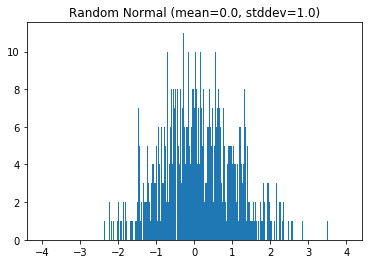

Applying weights: Uniform [-0.1, 0.1) vs Normal stddev=0.1

Building network ...
Network Built!

Training network ...
Network Trained!

Building network ...
Network Built!

Training network ...
Network Trained!



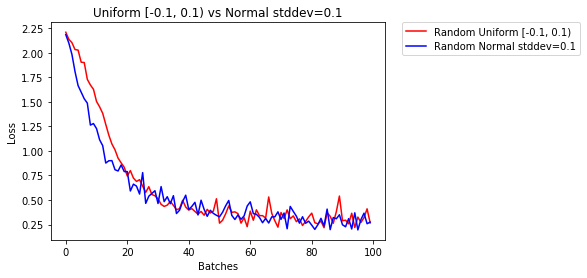

After 858 Batches (2 Epochs):
Validation Accuracy
   97.080% -- Random Uniform [-0.1, 0.1)
   96.900% -- Random Normal stddev=0.1
Loss
    0.089  -- Random Uniform [-0.1, 0.1)
    0.038  -- Random Normal stddev=0.1


In [14]:
experiment.run_uniform_01_vs_random_normal()

### Random Normal vs Truncated Normal

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # This is added back by InteractiveShellApp.init_path()


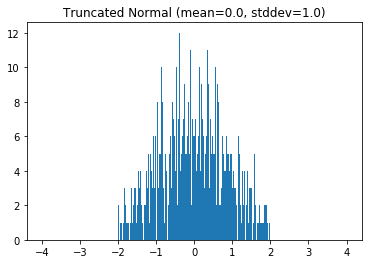

Applying weights: Random Normal stddev=0.1 vs Truncated Normal stddev=0.1

Building network ...
Network Built!

Training network ...
Network Trained!

Building network ...
Network Built!

Training network ...
Network Trained!



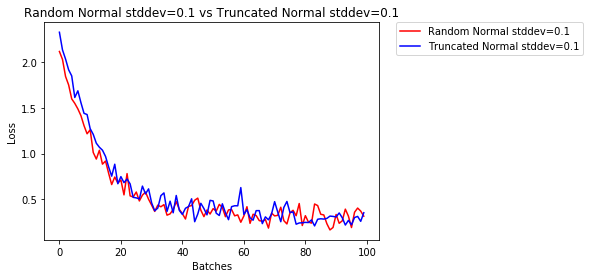

After 858 Batches (2 Epochs):
Validation Accuracy
   97.380% -- Random Normal stddev=0.1
   97.200% -- Truncated Normal stddev=0.1
Loss
    0.111  -- Random Normal stddev=0.1
    0.057  -- Truncated Normal stddev=0.1


In [15]:
experiment.run_random_normal_vs_truncated_normal()

### Baseline vs Truncated Normal

Applying weights: Baseline [0, 1) vs Truncated Normal

Building network ...
Network Built!

Training network ...
Network Trained!

Building network ...
Network Built!

Training network ...
Network Trained!



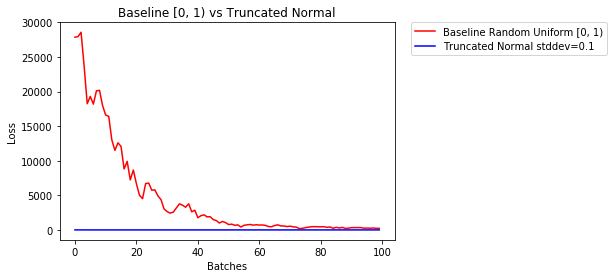

After 858 Batches (2 Epochs):
Validation Accuracy
   73.340% -- Baseline Random Uniform [0, 1)
   96.900% -- Truncated Normal stddev=0.1
Loss
   18.576  -- Baseline Random Uniform [0, 1)
    0.080  -- Truncated Normal stddev=0.1


In [16]:
experiment.run_baseline_vs_truncated_normal()